<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
import warnings
warnings.filterwarnings("ignore")


In [2]:

#Start Here
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('../module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip')
print(df.shape)
df.head()

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:169: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

(28332, 24)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."


In [3]:
from spacy import load as sp_load
from pandarallel import pandarallel
nlp = sp_load('en_core_web_lg')


#progress_bar=True causes problems -  parallel_apply() never seems to complete - works fine with default progress_bar=False
pandarallel.initialize()

df['reviews_lemmas'] = df['reviews.text'].parallel_apply(lambda x:[token.lemma_ for token in nlp(x) if (token.is_stop == False and token.is_punct == False and token.pos_ != 'PRON')])

df.head(3)

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,reviews_lemmas
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...","[order, 3, item, bad, quality, miss, backup, s..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...","[bulk, expensive, way, product, like]"
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...","[Duracell, price, happy]"


In [5]:
# Create Dictionary

# Term Document Frequency

# stores (token id, token count) for each doc in the corpus

# Human readable format of corpus (term-frequency)

id2word = corpora.Dictionary(df.reviews_lemmas)
corpus = [id2word.doc2bow(text) for text in df.reviews_lemmas]

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# How many words are in our vocab?
len(id2word.keys())

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


9706

In [7]:
display(df.reviews_lemmas.iloc[5])
corpus[5]

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['buy',
 'lot',
 'battery',
 'Christmas',
 'AmazonBasics',
 'Cell',
 'good',
 'notice',
 'difference',
 'brand',
 'battery',
 'Amazon',
 'Basic',
 'brand',
 'lot',
 'easy',
 'purchase',
 'arrive',
 'house',
 'hand',
 'buy']

[(4, 2),
 (20, 2),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 2),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 2),
 (38, 1),
 (39, 1)]

In [8]:
[(id2word[word_id], word_count) for word_id, word_count in corpus[5]]

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('battery', 2),
 ('brand', 2),
 ('Amazon', 1),
 ('AmazonBasics', 1),
 ('Basic', 1),
 ('Cell', 1),
 ('Christmas', 1),
 ('arrive', 1),
 ('buy', 2),
 ('difference', 1),
 ('easy', 1),
 ('good', 1),
 ('hand', 1),
 ('house', 1),
 ('lot', 2),
 ('notice', 1),
 ('purchase', 1)]

In [4]:
display(df.primaryCategories.value_counts())


/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Electronics,Furniture              2
Home & Garden                      2
Name: primaryCategories, dtype: int64

In [9]:
id2word[26]

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'AmazonBasics'

In [10]:
%%time
lda_multicore = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=5, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=16)


lda_multicore.save('amzn_lda_multicore.model')

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 10.8 s, sys: 863 ms, total: 11.7 s
Wall time: 11.4 s


In [11]:
from gensim import models
lda_multicore =  models.LdaModel.load('amzn_lda_multicore.model')

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# display the print_topics from the model 
pprint(lda_multicore.print_topics())

[(0,
  '0.045*"love" + 0.042*"easy" + 0.041*"use" + 0.022*"great" + 0.015*"nice" + '
  '0.014*"light" + 0.012*"reading" + 0.011*"Kindle" + 0.010*"sound" + '
  '0.010*"like"'),
 (1,
  '0.017*"Fire" + 0.017*"battery" + 0.016*"screen" + 0.015*"Amazon" + '
  '0.014*"use" + 0.014*"buy" + 0.011*"device" + 0.009*"like" + 0.008*"work" + '
  '0.007*"need"'),
 (2,
  '0.150*"good" + 0.070*"great" + 0.069*"price" + 0.055*"book" + '
  '0.041*"product" + 0.027*"work" + 0.019*"value" + 0.014*"quality" + '
  '0.014*"fast" + 0.014*"far"'),
 (3,
  '0.065*"tablet" + 0.037*"love" + 0.021*"old" + 0.020*"great" + 0.020*"app" + '
  '0.020*"kid" + 0.019*"buy" + 0.017*"use" + 0.017*"year" + 0.016*"game"'),
 (4,
  '0.116*"battery" + 0.058*"great" + 0.045*"price" + 0.040*"work" + '
  '0.035*"long" + 0.032*"brand" + 0.024*"buy" + 0.020*"good" + 0.016*"cheap" + '
  '0.015*"Amazon"')]


/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
display(df.reviews_lemmas.iloc[1])
doc_lda = lda_multicore[corpus]
doc_lda[1][0]

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['bulk', 'expensive', 'way', 'product', 'like']

[(0, 0.033860054),
 (1, 0.03392366),
 (2, 0.034497257),
 (3, 0.033656616),
 (4, 0.86406237)]

In [14]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore, corpus, id2word)
vis

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.211068 -0.073276       1        1  33.226525
1     -0.052954  0.207511       2        1  25.979752
4      0.200672  0.099462       3        1  18.681143
0     -0.167933 -0.074179       4        1  11.429490
2      0.231283 -0.159518       5        1  10.683090, topic_info=         Term         Freq        Total Category  logprob  loglift
34       good  6690.000000  6690.000000  Default  30.0000  30.0000
4     battery  8605.000000  8605.000000  Default  29.0000  29.0000
3953   tablet  7157.000000  7157.000000  Default  28.0000  28.0000
19      price  5280.000000  5280.000000  Default  27.0000  27.0000
22      great  9227.000000  9227.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
31        buy   374.579757  5591.455298   Topic5  -4.5432  -0.4667
646   picture   169.868379   457.789204   Topic5  -5.3340   1.2451
183       kid   214.484665  2664.274239   Topic5  -5.1008  -0.2829
172      nice   190.991039  1303.573612   Topic5  -5.2168   0.3159
895      read   199.576293  1991.913259   Topic5  -5.1728  -0.0641

[365 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
5718      1  0.974777      $
5718      5  0.022669      $
5673      4  0.968673    1st
212       1  0.495576      2
212       2  0.497854      2
...     ...       ...    ...
100       3  0.006145   year
100       4  0.003782   year
1109      1  0.991844  young
1109      3  0.004331  young
1456      4  0.997150     yr

[686 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 1, 3])

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f'num_topics = {num_topics}')
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=16)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df.reviews_lemmas, limit=22)

num_topics = 2


/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


num_topics = 5
num_topics = 8
num_topics = 11
num_topics = 14
num_topics = 17
num_topics = 20
CPU times: user 1min 46s, sys: 10.3 s, total: 1min 56s
Wall time: 1min 56s


In [17]:
print(coherence_values)

[0.44188890501473754, 0.49924378814314974, 0.4562979925071317, 0.45002848059181083, 0.42866160004712045, 0.4228437384677316, 0.4133101148976113]


/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


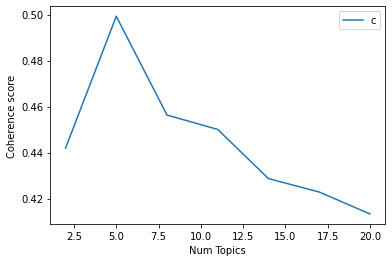

In [18]:
limit=22; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


Based on the value_counts() for the primaryCategories column

Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Electronics,Furniture              2
Home & Garden                      2

I estimated the number of topics as 5 and generated LDA numbers.


The choice of 5 for the number of topics appears to be validated by the coherence score metric which peaks at num_topics == 5.


## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling